demo : Reuters newswire topics (Keras dataset)

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from feature_eng import WordAndDoc2vec

In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
import random
from collections import defaultdict, Counter
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.sequence import skipgrams
import tensorflow as tf

In [4]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, cmap=cmap, **kwargs)
def scatter(x, y, color, **kwargs):
    plt.scatter(x, y, marker='.')

### load data

In [5]:
from keras.datasets import reuters

In [6]:
word_index = reuters.get_word_index()
word_index2 = dict([(k, v+3) for k, v in word_index.items()])
word_dic = gensim.corpora.Dictionary([['<padding>', '<start_char>', '<oov_char>'],], prune_at=None)
word_dic.token2id.update(word_index2)

In [7]:
word_dic[27595]

'mcgrath'

In [8]:
word_dic[4]

'the'

In [9]:
(doc, cat), (doc_test, cat_test) = reuters.load_data(test_split=0.0, start_char=None)

In [10]:
' '.join([word_dic[ee] for ee in doc[0]])

'mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [11]:
doc_dic = gensim.corpora.Dictionary(prune_at=None)
doc_dic.token2id.update(dict([('d'+str(ee+1), ee) for ee in range(len(doc))]))

In [12]:
doc_seq = [[word_dic[ee] for ee in doc[ii]] for ii in range(len(doc))]

In [13]:
cat
cls = pd.Series(['c'+str(c) for c in cat])

### create WordAndDoc2vec instance

In [14]:
wd2v = WordAndDoc2vec(doc_seq, word_dic, doc_dic, logging=False)
wd2v

len(doc_seq) >>> 11228
max(doc_dic.keys()) + 1 >>> 11228
num_features >>> 30983
corpus_csr.shape >>> (11228, 30983)
creating tfidf...


### create model

In [15]:
num_features = 96
wd2v.make_model(max_num_prod=5, num_neg=3, num_features=num_features,
                embeddings_val=0.5, gamma=0.0)

{'model': <keras.engine.training.Model at 0x7f169bb4d7f0>,
 'model_neg': <keras.engine.training.Model at 0x7f169b39dfd0>,
 'model_prob': <keras.engine.training.Model at 0x7f169ba4d358>,
 'model_prob2': <keras.engine.training.Model at 0x7f169bea4ba8>,
 'model_prob2_cnfm': <keras.engine.training.Model at 0x7f169ba8c9e8>,
 'model_prob_cnfm': <keras.engine.training.Model at 0x7f169b712860>,
 'model_prod': <keras.engine.training.Model at 0x7f169b412e48>,
 'model_user': <keras.engine.training.Model at 0x7f169b4126a0>}

### start train
note : it will take a long time...

In [16]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

# def lr_schedule(epoch):
#     lr0 = 0.02
#     epoch1 = 32
#     epoch2 = 32
#     epoch3 = 32
#     epoch4 = 32
    
#     if epoch<epoch1:
#         lr = lr0
#     elif epoch<epoch1+epoch2:
#         lr = lr0/2
#     elif epoch<epoch1+epoch2+epoch3:
#         lr = lr0/4
#     elif epoch<epoch1+epoch2+epoch3+epoch4:
#         lr = lr0/8
#     else:
#         lr = lr0/16
    
#     if divmod(epoch,4)[1] == 3:
#         lr *= (1/8)
#     elif divmod(epoch,4)[1] == 2:
#         lr *= (1/4)
#     elif divmod(epoch,4)[1] == 1:
#         lr *= (1/2)
#     elif divmod(epoch,4)[1] == 0:
#         pass
#     print('Learning rate: ', lr)
#     return lr

# lr_scheduler = LearningRateScheduler(lr_schedule)
# callbacks = [lr_scheduler]

# wd2v.train(epochs=128, verbose=1,
#            use_multiprocessing=True, workers=4,
#            callbacks=callbacks)

In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

def lr_schedule(epoch):
    lr0 = 0.02
    epoch1 = 16
    epoch2 = 16
    epoch3 = 32
    epoch4 = 32
    
    if epoch<epoch1:
        lr = lr0
    elif epoch<epoch1+epoch2:
        lr = lr0/2
    elif epoch<epoch1+epoch2+epoch3:
        lr = lr0/4
    elif epoch<epoch1+epoch2+epoch3+epoch4:
        lr = lr0/8
    else:
        lr = lr0/16
    
    if divmod(epoch,4)[1] == 3:
        lr *= (1/8)
    elif divmod(epoch,4)[1] == 2:
        lr *= (1/4)
    elif divmod(epoch,4)[1] == 1:
        lr *= (1/2)
    elif divmod(epoch,4)[1] == 0:
        pass
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [lr_scheduler]

wd2v.train(epochs=96, verbose=1,
           use_multiprocessing=True, workers=4,
           callbacks=callbacks)

len(seq) >>> 351
Epoch 1/96
Learning rate:  0.02
351/351 [==============================] - 49s 139ms/step - loss: 0.4029 - acc: 0.8130
Epoch 2/96
Learning rate:  0.01
351/351 [==============================] - 49s 139ms/step - loss: 0.2915 - acc: 0.8904
Epoch 3/96
Learning rate:  0.005
351/351 [==============================] - 49s 139ms/step - loss: 0.2598 - acc: 0.9042
Epoch 4/96
Learning rate:  0.0025
351/351 [==============================] - 49s 139ms/step - loss: 0.2524 - acc: 0.9077
Epoch 5/96
Learning rate:  0.02
351/351 [==============================] - 49s 139ms/step - loss: 0.2649 - acc: 0.9086
Epoch 6/96
Learning rate:  0.01
351/351 [==============================] - 49s 138ms/step - loss: 0.2520 - acc: 0.9127
Epoch 7/96
Learning rate:  0.005
351/351 [==============================] - 49s 140ms/step - loss: 0.2411 - acc: 0.9151
Epoch 8/96
Learning rate:  0.0025
351/351 [==============================] - 49s 140ms/step - loss: 0.2317 - acc: 0.9188
Epoch 9/96
Learning rate:

351/351 [==============================] - 49s 139ms/step - loss: 0.2090 - acc: 0.9194
Epoch 69/96
Learning rate:  0.0025
351/351 [==============================] - 49s 139ms/step - loss: 0.2113 - acc: 0.9184
Epoch 70/96
Learning rate:  0.00125
351/351 [==============================] - 49s 139ms/step - loss: 0.2101 - acc: 0.9186
Epoch 71/96
Learning rate:  0.000625
351/351 [==============================] - 49s 139ms/step - loss: 0.2095 - acc: 0.9194
Epoch 72/96
Learning rate:  0.0003125
351/351 [==============================] - 49s 140ms/step - loss: 0.2090 - acc: 0.9195
Epoch 73/96
Learning rate:  0.0025
351/351 [==============================] - 49s 139ms/step - loss: 0.2112 - acc: 0.9184
Epoch 74/96
Learning rate:  0.00125
351/351 [==============================] - 49s 139ms/step - loss: 0.2103 - acc: 0.9185
Epoch 75/96
Learning rate:  0.000625
351/351 [==============================] - 49s 139ms/step - loss: 0.2095 - acc: 0.9194
Epoch 76/96
Learning rate:  0.0003125
351/351 [===

In [18]:
# wd2v.train(epochs=128, verbose=1,
#            use_multiprocessing=True, workers=4)

In [19]:
hst_history = wd2v.hst.history

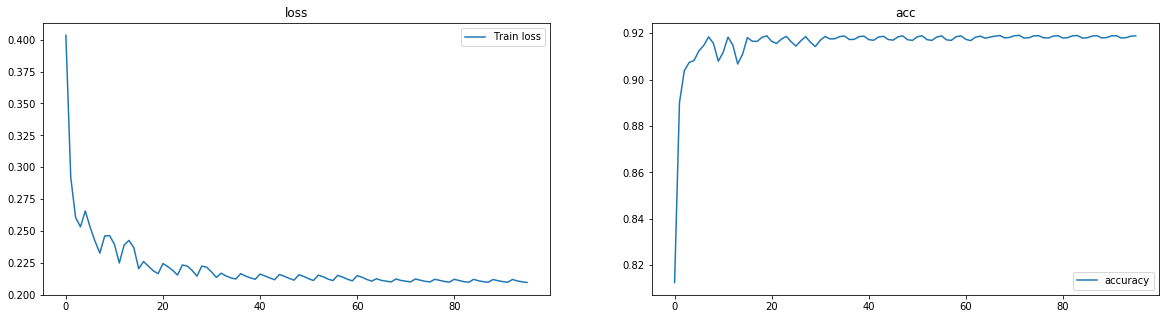

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst_history["loss"]))), hst_history["loss"], label="Train loss")
ax[1].set_title('acc')
ax[1].plot(list(range(len(hst_history["loss"]))), hst_history["acc"], label="accuracy")
ax[0].legend()
ax[1].legend()

## similarity

In [21]:
sim = wd2v.sim
print(sim.num_features)
print(sim.sim_row)
sim

96
MatrixSimilarity<11228 docs, 96 features>


### get feature vector of document 'd1'

In [22]:
'''d1'''
' '.join([word_dic[ee] for ee in doc[sim.row_dic.token2id['d1']]])

'mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [23]:
query = sim.sim_row.index[sim.row_dic.token2id['d1']]
query

array([ 0.04953795,  0.09779952,  0.02991736, -0.0824597 , -0.11490261,
        0.04240257,  0.04140015, -0.13066047,  0.0137052 ,  0.0822317 ,
       -0.13764028, -0.02017038,  0.09443422,  0.01405507,  0.08238728,
       -0.01725909,  0.03521468,  0.02052623,  0.07153013, -0.03767006,
       -0.15103996,  0.03980536, -0.06288578,  0.24582623, -0.05753605,
        0.1080571 ,  0.1243905 , -0.07431678,  0.03531686,  0.00964819,
        0.0295229 , -0.09510512,  0.05343136,  0.0786027 ,  0.00193327,
       -0.07161225, -0.11391889, -0.17396602,  0.06655008, -0.03114389,
       -0.10004482,  0.06427718, -0.11440732, -0.0368393 ,  0.12284756,
        0.03382453,  0.03514974,  0.09553713, -0.10260361,  0.09717236,
        0.12339882,  0.08343758,  0.19161224,  0.14940439, -0.09049399,
       -0.18215601,  0.21042347, -0.00090432,  0.0545822 , -0.05325332,
        0.07544312, -0.0649778 , -0.06881188,  0.14188825, -0.04380903,
       -0.04760855, -0.11325315,  0.05843481, -0.02645697, -0.11

In [24]:
'''get words that are highly correlated with this document ('d1')'''
sim.get_sim_bycol(query, num_best=20)

[('rentcorp', 0.881993293762207),
 ('mcgrath', 0.8800176978111267),
 ('earnings', 0.7683566808700562),
 ('dlrs', 0.7246045470237732),
 ('revenues', 0.7229360342025757),
 ('operating', 0.7197266817092896),
 ('operations', 0.7153149843215942),
 ('assets', 0.7137821912765503),
 ('income', 0.7122267484664917),
 ('results', 0.7095717787742615),
 ('name', 0.7078500986099243),
 ('quarter', 0.7044647336006165),
 ('share', 0.6997177004814148),
 ('sale', 0.6955611109733582),
 ('corrects', 0.6952757239341736),
 ('gain', 0.6940920948982239),
 ('881', 0.6934512853622437),
 ('dividends', 0.6899479627609253),
 ('restated', 0.6888561248779297),
 ('reversion', 0.687865674495697)]

In [25]:
'''get documents that are highly correlated with this document ('d1')'''
sim.get_sim_byrow(query, num_best=10)

[('d1', 1.0),
 ('d7985', 0.8006864786148071),
 ('d9165', 0.7511889934539795),
 ('d4589', 0.7490085959434509),
 ('d8160', 0.7417320013046265),
 ('d3041', 0.7381963729858398),
 ('d3857', 0.7381172776222229),
 ('d7958', 0.7315175533294678),
 ('d3083', 0.7309119701385498),
 ('d9302', 0.7308659553527832)]

In [26]:
' '.join([word_dic[ee] for ee in doc[sim.row_dic.token2id['d9302']]])

'cardinal industries inc said it restated earnings for the first nine months of 1986 to 235 000 dlrs or nine cts per share from 485 000 dlrs or 18 cts reported previously due to the failure of an automated accounting system installed in mid year and replaced in the fourth quarter the company said its reliance segment sustained a significant operating loss for the full year 1986 due to the accounting problems and increased promotional and advertising expenses for the full year it said it earned 284 000 dlrs or 10 cts a share up from 271 000 dlrs or 10 cts in 1985 cardinal industries said revenues for the year were 30 7 mln dlrs up from 23 0 mln dlrs in 1985 the company said for the first quarter of 1987 earnings were about 48 000 dlrs up from 13 000 dlrs or nil per share in the year ago period the year ago first quarter earnings however have been restated from 101 000 dlrs or four cts per share it said sales for the first quarter were about 8 363 000 dlrs up from 6 636 000 dlrs for the 

### get feature vector of word 'rentcorp'

In [27]:
query = sim.sim_col.index[sim.col_dic.token2id['rentcorp']]
query

array([ 0.14695527,  0.07788703,  0.03571338, -0.0997583 , -0.13192277,
        0.05863317,  0.04816515, -0.08420668, -0.05881651,  0.02031794,
       -0.1704299 , -0.02298628,  0.09784427,  0.09564326,  0.03649498,
       -0.03342361,  0.04478186,  0.0716325 ,  0.00959602,  0.03302816,
       -0.14971164,  0.12099151, -0.06483851,  0.2020433 , -0.05085221,
        0.09251625,  0.15104076, -0.02247498, -0.04267238, -0.01084986,
        0.02007341, -0.10362314,  0.05876356,  0.09597515,  0.0018457 ,
       -0.05787843, -0.09376051, -0.15518159,  0.0789693 , -0.05129159,
       -0.11261822,  0.08310385, -0.12675577, -0.06198974,  0.17007631,
        0.03110785,  0.11347974,  0.07857743, -0.17076384,  0.03582275,
        0.07560284,  0.15014918,  0.12815732,  0.16021225, -0.02730003,
       -0.11554819,  0.17324877,  0.0560018 ,  0.06658019, -0.07521041,
        0.08101576,  0.02576939, -0.04342875,  0.09702627, -0.01735571,
       -0.04796585, -0.13135219,  0.20223711,  0.03127514, -0.11

In [28]:
'''get words that are highly correlated with this word ('rentcorp')'''
sim.get_sim_bycol(query, num_best=20)

[('rentcorp', 1.0),
 ('mcgrath', 0.9499125480651855),
 ('expects', 0.537687361240387),
 ('rental', 0.5341197848320007),
 ('cellular', 0.5183255672454834),
 ('revenues', 0.5104328393936157),
 ('earned', 0.5077186226844788),
 ('earnings', 0.4965617060661316),
 ('reseller', 0.4695873558521271),
 ('yearend', 0.46462297439575195),
 ('mortgage', 0.46441081166267395),
 ("hudson's", 0.459075391292572),
 ('first', 0.4567191004753113),
 ('master', 0.4556480348110199),
 ('trustco', 0.4521712064743042),
 ("budget's", 0.4453589618206024),
 ('unit', 0.4425507187843323),
 ('cash', 0.4393976330757141),
 ('acquisitions', 0.43618276715278625),
 ('accrued', 0.435133695602417)]

In [29]:
'''get documents that are highly correlated with this word ('rentcorp')'''
sim.get_sim_byrow(query, num_best=10)

[('d1', 0.881993293762207),
 ('d98', 0.5440433025360107),
 ('d10757', 0.5279454588890076),
 ('d7608', 0.519077718257904),
 ('d6333', 0.511250376701355),
 ('d3857', 0.5038752555847168),
 ('d3825', 0.5020995140075684),
 ('d7934', 0.4991131126880646),
 ('d8160', 0.4928939938545227),
 ('d7985', 0.4878692030906677)]